# Pulling Data from GCS and Clickhouse

In [ ]:
from op_analytics.coreutils.duckdb_inmem.client import init_client, register_parquet_relation
from op_analytics.coreutils.clickhouse.oplabs import run_query_oplabs

import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import mannwhitneyu

FLASHBLOCK_DATE = pd.Timestamp("2025-07-16")
NUM_DAYS = 7

pl.Config.set_tbl_cols(100)   # number of columns shown
pl.Config.set_tbl_rows(100)   # number of rows shown
pl.Config.set_fmt_str_lengths(80)  # max string preview length


In [ ]:
# Create dates before and after flashblock launch on base
start_date = FLASHBLOCK_DATE - pd.Timedelta(days=NUM_DAYS)
end_date = FLASHBLOCK_DATE + pd.Timedelta(days=NUM_DAYS)

dates = pd.date_range(start_date, end_date).strftime("%Y-%m-%d").tolist()
dates

['2025-07-09',
 '2025-07-10',
 '2025-07-11',
 '2025-07-12',
 '2025-07-13',
 '2025-07-14',
 '2025-07-15',
 '2025-07-16',
 '2025-07-17',
 '2025-07-18',
 '2025-07-19',
 '2025-07-20',
 '2025-07-21',
 '2025-07-22',
 '2025-07-23']

In [104]:
parquet_paths = [
    f"gs://oplabs-tools-data-sink/blockbatch/refined_traces/refined_transactions_fees_v2/chain=base/dt={date}/*.parquet"
    for date in dates
]

# Load into DuckDB
ctx = init_client()
tx_fees_view = register_parquet_relation("refined_transactions_fees_v2", parquet_paths)

2025-07-25 14:33:06 [info     ] registered view: 'refined_transactions_fees_v2' using 15 parquet paths filename=client.py lineno=319 process=8248


In [105]:
# Query the data
df = ctx.client.sql(f"SELECT * FROM {tx_fees_view} LIMIT 10").pl()
print(df)

shape: (10, 59)
┌──────────┬─────────┬──────────┬─────────────┬───┬─────────────┬─────────────┬───────┬────────────┐
│ chain_id ┆ network ┆ nonce    ┆ transaction ┆ … ┆ l1_base_gas ┆ l1_blob_bas ┆ chain ┆ dt         │
│ ---      ┆ ---     ┆ ---      ┆ _index      ┆   ┆ _price_gwei ┆ e_gas_price ┆ ---   ┆ ---        │
│ i32      ┆ str     ┆ i64      ┆ ---         ┆   ┆ ---         ┆ _gwei       ┆ str   ┆ date       │
│          ┆         ┆          ┆ i64         ┆   ┆ decimal[38, ┆ ---         ┆       ┆            │
│          ┆         ┆          ┆             ┆   ┆ 10]         ┆ decimal[38, ┆       ┆            │
│          ┆         ┆          ┆             ┆   ┆             ┆ 10]         ┆       ┆            │
╞══════════╪═════════╪══════════╪═════════════╪═══╪═════════════╪═════════════╪═══════╪════════════╡
│ 8453     ┆ mainnet ┆ 32615000 ┆ 0           ┆ … ┆ null        ┆ null        ┆ base  ┆ 2025-07-09 │
│ 8453     ┆ mainnet ┆ 925      ┆ 1           ┆ … ┆ 0.346375253 ┆ 0.0000000

In [106]:
# Query clickhouse 
query = "SELECT * FROM hex_uploads.likely_bot_contracts"
bot_labels_df = run_query_oplabs(query)
print(bot_labels_df.head())

# Register the view
ctx.client.register("likely_bot_contracts", bot_labels_df)

# Just use the name as a string
bot_labels_view = "likely_bot_contracts"


shape: (5, 1)
┌─────────────────────────────────┐
│ contract                        │
│ ---                             │
│ str                             │
╞═════════════════════════════════╡
│ 0x0000000000000000000000000000… │
│ 0x0000000000007c4cb8129fc2ae24… │
│ 0x000000000001467a230d332f2181… │
│ 0x0000000000020a4c8cb0fab88633… │
│ 0x0000000000034abbb84a1bf4a9e9… │
└─────────────────────────────────┘


In [107]:
formatted_flashblock_date = FLASHBLOCK_DATE.strftime("%Y-%m-%d")

TX_FEES_QUERY = (
    f"""
    SELECT 
        chain_id,
        network,
        dt,
        CASE 
            WHEN dt > '2025-07-16' THEN 'post-flashblock'
            ELSE 'pre-flashblock'
        END AS flashblock_period,
        to_address,
        transaction_index,
        hash,
        block_number,
        success,
        tx_fee_native,
        l1_fee_native,
        l2_base_fee_native,
        l2_priority_fee_native,
        l2_legacy_extra_fee_native,
        l2_gas_used,
        100 * l1_fee_native / tx_fee_native AS pct_l1_fee,
        100 * l2_base_fee_native / tx_fee_native AS pct_l2_base_fee,
        100 * l2_priority_fee_native / tx_fee_native AS pct_l2_priority_fee,
        100 * l2_legacy_extra_fee_native / tx_fee_native AS pct_l2_legacy_extra_fee
    FROM {tx_fees_view}
    SEMI JOIN {bot_labels_view} 
    ON {tx_fees_view}.to_address = {bot_labels_view}.contract
    """
)

# Query the data
combined_df = ctx.client.sql(TX_FEES_QUERY).pl()
print(combined_df)

RuntimeError: Query interrupted

In [ ]:
df_casted = combined_df.with_columns([
    pl.col("tx_fee_native").cast(pl.Float64),
    pl.col("l1_fee_native").cast(pl.Float64),
    pl.col("l2_base_fee_native").cast(pl.Float64),
    pl.col("l2_priority_fee_native").cast(pl.Float64),
    pl.col("l2_legacy_extra_fee_native").cast(pl.Float64)
])

# Pre and Post Flashblock Summary

In [109]:
summary_tx_level = df_casted.group_by("flashblock_period").agg([
    pl.col("tx_fee_native").mean().alias("avg_tx_fee_native"),
    pl.col("l1_fee_native").mean().alias("avg_l1_fee_native"),
    pl.col("l2_base_fee_native").mean().alias("avg_l2_base_fee_native"),
    pl.col("l2_priority_fee_native").mean().alias("avg_l2_priority_fee_native"),
    pl.col("l2_legacy_extra_fee_native").mean().alias("avg_l2_legacy_extra_fee_native"),
    pl.col("l2_gas_used").mean().alias("avg_l2_gas_used")
])

summary_tx_level

flashblock_period,avg_tx_fee_native,avg_l1_fee_native,avg_l2_base_fee_native,avg_l2_priority_fee_native,avg_l2_legacy_extra_fee_native,avg_l2_gas_used
str,f64,f64,f64,f64,f64,f64
"""pre-flashblock""",0.000006,3.7435e-8,0.000001,0.000004,8.5599e-7,305096.05479
"""post-flashblock""",0.000007,2.2352e-8,0.000003,0.000003,0.000001,296442.142095


In [110]:
bot_block_level_df = df_casted.group_by([
    "flashblock_period",
    "dt",
    "to_address",
    "block_number"
]).agg([
    pl.len().alias("tx_count"),
    pl.sum("tx_fee_native").alias("total_fee"),
    pl.sum("l1_fee_native").alias("total_l1_fee"),
    pl.sum("l2_base_fee_native").alias("total_l2_base_fee"),
    pl.sum("l2_priority_fee_native").alias("total_l2_priority_fee"),
    pl.sum("l2_legacy_extra_fee_native").alias("total_l2_legacy_fee"),
    pl.sum("l2_gas_used").alias("total_gas_used"),
    pl.sum("success").alias("total_success"),
    
    pl.mean("pct_l1_fee").alias("avg_pct_l1_fee"),
    pl.mean("pct_l2_base_fee").alias("avg_pct_l2_base_fee"),
    pl.mean("pct_l2_priority_fee").alias("avg_pct_l2_priority_fee"),
    pl.mean("pct_l2_legacy_extra_fee").alias("avg_pct_l2_legacy_fee"),
])


In [112]:
summary_block_level = bot_block_level_df.group_by("flashblock_period").agg([
    pl.mean("tx_count").alias("avg_tx_per_block"),
    pl.mean("total_fee").alias("avg_total_fee_per_block"),
    pl.mean("total_l1_fee").alias("avg_l1_fee_per_block"),
    pl.mean("total_l2_base_fee").alias("avg_l2_base_fee_per_block"),
    pl.mean("total_l2_priority_fee").alias("avg_l2_priority_fee_per_block"),
    pl.mean("total_l2_legacy_fee").alias("avg_l2_legacy_fee_per_block"),
    pl.mean("total_gas_used").alias("avg_gas_used_per_block"),
    (pl.sum("total_success") / pl.sum("tx_count")).alias("avg_tx_success_rate_per_block"),
    pl.mean("avg_pct_l1_fee").alias("avg_pct_l1_fee_per_block"),
    pl.mean("avg_pct_l2_base_fee").alias("avg_pct_l2_base_fee_per_block"),
    pl.mean("avg_pct_l2_priority_fee").alias("avg_pct_l2_priority_fee_per_block"),
    pl.mean("avg_pct_l2_legacy_fee").alias("avg_pct_l2_legacy_fee_per_block")
])

summary_block_level

flashblock_period,avg_tx_per_block,avg_total_fee_per_block,avg_l1_fee_per_block,avg_l2_base_fee_per_block,avg_l2_priority_fee_per_block,avg_l2_legacy_fee_per_block,avg_gas_used_per_block,avg_tx_success_rate_per_block,avg_pct_l1_fee_per_block,avg_pct_l2_base_fee_per_block,avg_pct_l2_priority_fee_per_block,avg_pct_l2_legacy_fee_per_block
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""post-flashblock""",3.116083,0.000023,6.9652e-8,0.000009,0.00001,0.000004,923738.216483,0.871027,0.915693,67.242494,22.354688,9.487126
"""pre-flashblock""",2.394584,0.000014,8.9641e-8,0.000003,0.000009,0.000002,730578.225922,0.84483,3.041711,51.586259,32.411048,12.960982


# Stats and Visualization

In [136]:
block_df = df_casted.group_by(["flashblock_period", "block_number"]).agg([
    pl.len().alias("tx_count"),
    pl.sum("l2_gas_used").alias("total_gas_used"),
    pl.sum("tx_fee_native").alias("total_fee"),
    pl.sum("l1_fee_native").alias("total_l1_fee"),
    pl.sum("l2_base_fee_native").alias("total_l2_base_fee"),
    pl.sum("l2_priority_fee_native").alias("total_l2_priority_fee"),
    pl.sum("l2_legacy_extra_fee_native").alias("total_l2_legacy_fee"),
])

block_df_pd = block_df.to_pandas()


In [ ]:
def compute_stat_summary(df, col):
    pre = df[df["flashblock_period"] == "pre-flashblock"][col]
    post = df[df["flashblock_period"] == "post-flashblock"][col]
    
    stat, p = mannwhitneyu(pre, post, alternative="two-sided")
    med_pre = np.median(pre)
    med_post = np.median(post)
    delta = med_post - med_pre
    
    return p, delta, med_pre, med_post

def plot_kde_with_stats(df, col, xlabel=None, title=None, clip_percentiles=(0.01, 0.99)):
    # Optional clipping to remove outliers
    q_low = df[col].quantile(clip_percentiles[0])
    q_high = df[col].quantile(clip_percentiles[1])
    df_clipped = df[(df[col] >= q_low) & (df[col] <= q_high)]

    # Compute stats
    p, delta, med_pre, med_post = compute_stat_summary(df, col)

    # Plot
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df_clipped, x=col, hue="flashblock_period", fill=True, common_norm=False, alpha=0.5)
    
    # Annotation
    xlabel = xlabel or col
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.axvline(med_pre, linestyle="--", label=f"Pre-flashblock median", alpha=0.6, color="orange")
    plt.axvline(med_post, linestyle="--", label=f"Post-flashblock median", alpha=0.6, color="blue")

    stat_text = f"Δ median = {delta:.3g}, p = {p:.2e}"
    plt.title(f"{title or xlabel}\n{stat_text} ")
    plt.tight_layout()
    plt.show()


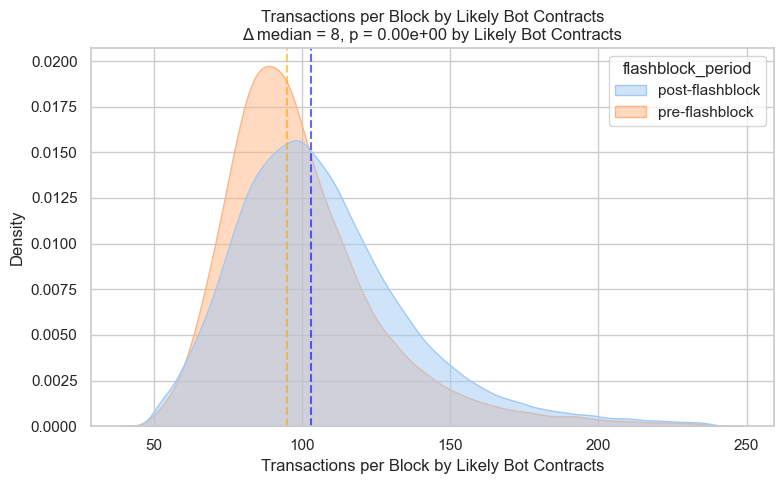

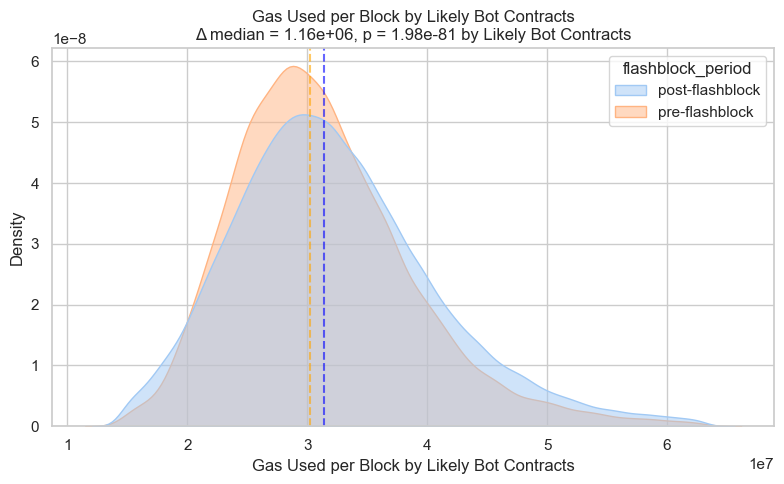

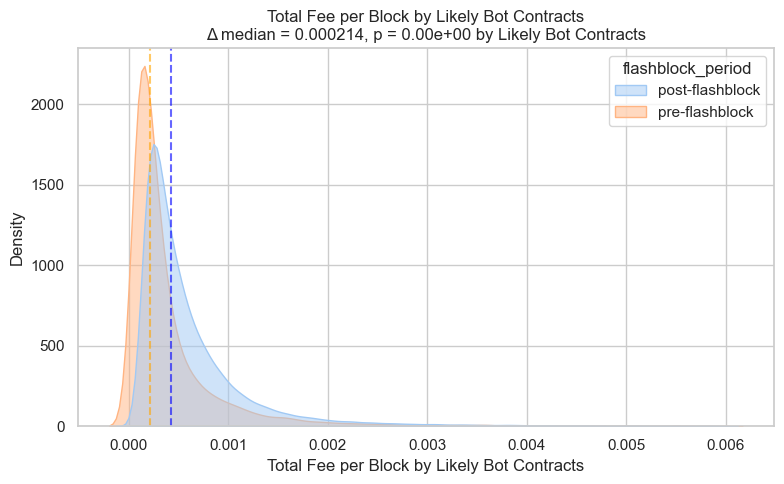

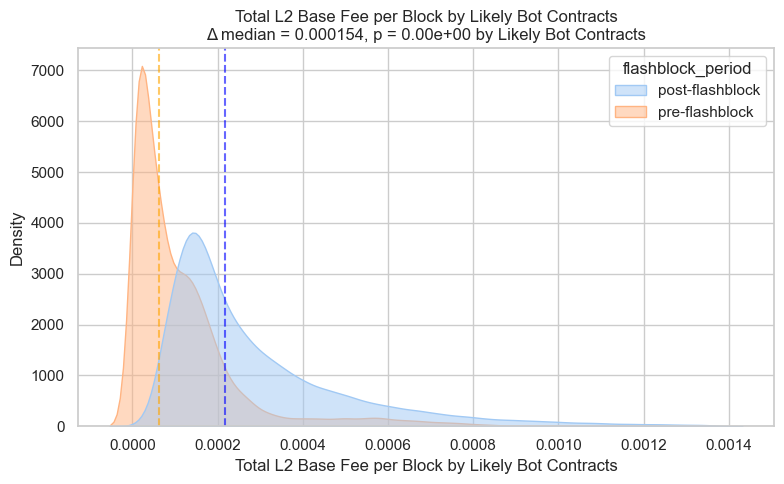

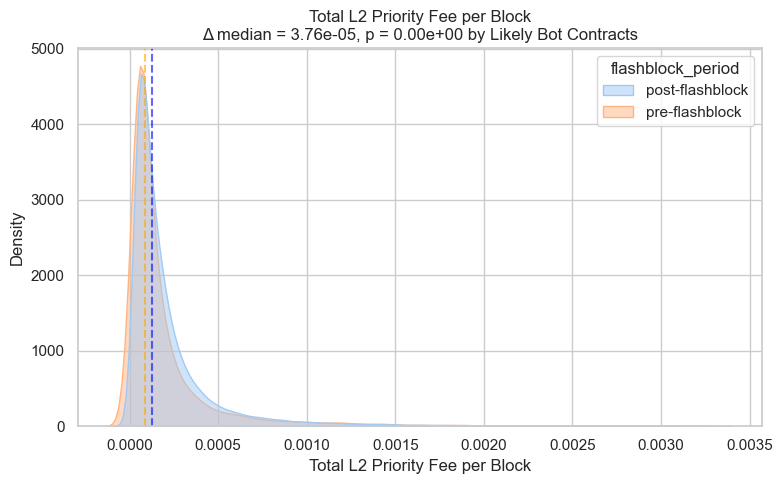

In [149]:
plot_kde_with_stats(block_df_pd, "tx_count", xlabel="Transactions per Block by Likely Bot Contracts")
plot_kde_with_stats(block_df_pd, "total_gas_used", xlabel="Gas Used per Block by Likely Bot Contracts")
plot_kde_with_stats(block_df_pd, "total_fee", xlabel="Total Fee per Block by Likely Bot Contracts")
plot_kde_with_stats(block_df_pd, "total_l2_base_fee", xlabel="Total L2 Base Fee per Block by Likely Bot Contracts")
plot_kde_with_stats(block_df_pd, "total_l2_priority_fee", xlabel="Total L2 Priority Fee per Block")


In [ ]:
SAMPLE_SIZE = 50000

# Get the unique values for flashblock_period
periods = df_casted.select("flashblock_period").unique().to_series().to_list()

# Sample each group separately
sampled_frames = []
for period in periods:
    sampled = (
        df_casted
        .filter(pl.col("flashblock_period") == period)
        .sample(n=SAMPLE_SIZE, seed=42)
    )
    sampled_frames.append(sampled)

# Concatenate all sampled groups
sampled_df = pl.concat(sampled_frames).to_pandas()

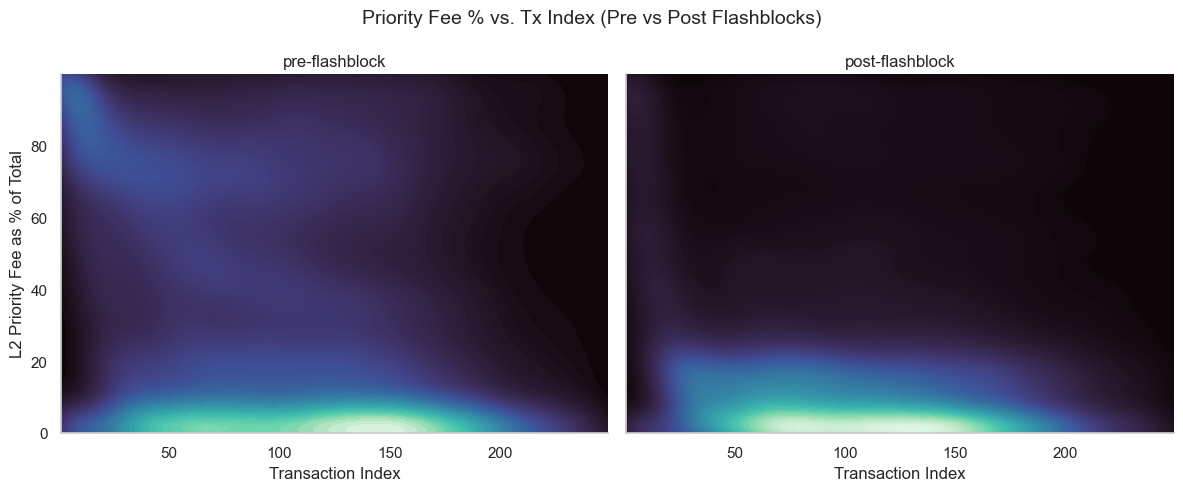

In [ ]:
sampled_df = sampled_df[sampled_df["transaction_index"] <= 250]

g = sns.FacetGrid(
    sampled_df,
    col="flashblock_period",
    height=5,
    aspect=1.2,
    sharex=True,
    sharey=True
)


# Map KDE plot onto each facet
g.map_dataframe(
    sns.kdeplot,
    x="transaction_index",
    y="pct_l2_priority_fee",
    fill=True,
    thresh=0,
    levels=100,
    cmap="mako",
    common_norm=False,
    cut = 0
)

# Titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Transaction Index", "L2 Priority Fee as % of Total")
g.fig.subplots_adjust(top=0.85)
stat_text = f"{SAMPLE_SIZE} samples with tx_index <= 250"
g.fig.suptitle("Priority Fee % vs. Tx Index (Pre vs Post Flashblocks)", fontsize=14)


plt.show()

# Looking at bot level data

In [177]:
bot_level_df = df_casted.group_by([
    "flashblock_period",
    "to_address",
]).agg([
    pl.len().alias("tx_count"),
    pl.n_unique("block_number").alias("block_count"),
    pl.sum("tx_fee_native").alias("total_fee"),
    pl.sum("l1_fee_native").alias("total_l1_fee"),
    pl.sum("l2_base_fee_native").alias("total_l2_base_fee"),
    pl.sum("l2_priority_fee_native").alias("total_l2_priority_fee"),
    pl.sum("l2_legacy_extra_fee_native").alias("total_l2_legacy_fee"),
    pl.sum("l2_gas_used").alias("total_gas_used"),
    pl.sum("success").alias("total_success"),

    (pl.len().alias("tx_count") / pl.n_unique("block_number")).alias("avg_tx_per_block"),
    pl.mean("tx_fee_native").alias("avg_tx_fee"),
    pl.mean("l1_fee_native").alias("avg_l1_fee"),
    pl.mean("l2_base_fee_native").alias("avg_l2_base_fee"),
    pl.mean("l2_priority_fee_native").alias("avg_l2_priority_fee"),
    pl.mean("l2_legacy_extra_fee_native").alias("avg_l2_legacy_fee"),
    pl.mean("l2_gas_used").alias("avg_l2_gas_used"),

    pl.mean("pct_l1_fee").alias("avg_pct_l1_fee"),
    pl.mean("pct_l2_base_fee").alias("avg_pct_l2_base_fee"),
    pl.mean("pct_l2_priority_fee").alias("avg_pct_l2_priority_fee"),
    pl.mean("pct_l2_legacy_extra_fee").alias("avg_pct_l2_legacy_fee"),
])


In [244]:
COL_TO_RANK = "tx_count"

bot_tx_totals = (
    bot_level_df
    .to_pandas()
    .groupby("to_address", as_index=False)[COL_TO_RANK]
    .sum()
    .sort_values(COL_TO_RANK, ascending=False)
)

bot_tx_totals["tx_cumsum"] = bot_tx_totals["tx_count"].cumsum()
total_txs = bot_tx_totals["tx_count"].sum()
bot_tx_totals["tx_cum_pct"] = bot_tx_totals["tx_cumsum"] / total_txs


54 bots account for 79.89% of all txs.


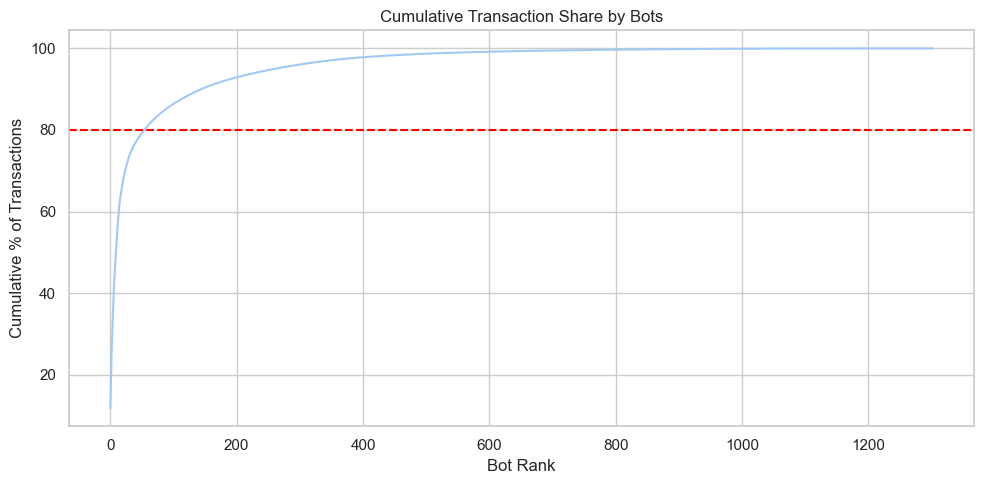

In [245]:
# filter to bots that make up more than 80% of total txs
top_bots = bot_tx_totals[bot_tx_totals["tx_cum_pct"] <= 0.80]
print(f"{len(top_bots)} bots account for {top_bots['tx_cum_pct'].max():.2%} of all txs.")

plt.figure(figsize=(10, 5))
plt.plot(bot_tx_totals["tx_cum_pct"].values * 100)
plt.axhline(80, color='red', linestyle='--')
plt.title("Cumulative Transaction Share by Bots")
plt.xlabel("Bot Rank")
plt.ylabel("Cumulative % of Transactions")
plt.tight_layout()
plt.show()

In [246]:
df_top_bots = bot_level_df.filter(pl.col("to_address").is_in(top_bots["to_address"]))

top_bot_with_both_periods = (
    df_top_bots
    .group_by("to_address")
    .agg(pl.n_unique("flashblock_period").alias("period_count"))
    .filter(pl.col("period_count") == 2)
    .select("to_address")
)

# Keep only bots with both pre and post entries
df_top_bots_with_both = df_top_bots.join(top_bot_with_both_periods, on="to_address")


In [247]:
df = df_top_bots_with_both.to_pandas()


# Pivot on flashblock period
pivoted = df.pivot(index="to_address", columns="flashblock_period")

# Flatten multi-index columns
pivoted.columns = ["_".join(col).strip() for col in pivoted.columns]
pivoted = pivoted.dropna()

pivoted["delta_tx_per_block"] = pivoted["avg_tx_per_block_post-flashblock"] - pivoted["avg_tx_per_block_pre-flashblock"]
pivoted["delta_priority_fee"] = pivoted["avg_l2_priority_fee_post-flashblock"] - pivoted["avg_l2_priority_fee_pre-flashblock"]
pivoted["delta_base_fee"] = pivoted["avg_l2_base_fee_post-flashblock"] - pivoted["avg_l2_base_fee_pre-flashblock"]
pivoted["delta_gas_used"] = pivoted["avg_l2_gas_used_post-flashblock"] - pivoted["avg_l2_gas_used_pre-flashblock"]


In [252]:
def plot_delta_dumbbell(
    df, 
    pre_col, 
    post_col, 
    delta_col, 
    title, 
    xlabel, 
    figsize=(10, 12), 
    unit="", 
    color_pre="black", 
    color_post="dodgerblue"
):
    df = df.sort_values(delta_col)
    y = range(len(df))

    fig, ax = plt.subplots(figsize=figsize)

    # Horizontal connecting lines
    ax.hlines(y, df[pre_col], df[post_col], color="lightgray", linewidth=2, zorder=1)

    # Pre dots
    ax.scatter(df[pre_col], y, color=color_pre, s=60, zorder=2, label="Pre")
    # Post dots
    ax.scatter(df[post_col], y, color=color_post, s=60, zorder=3, label="Post")

    # Delta box labels
    for i, (start, end, delta) in enumerate(zip(df[pre_col], df[post_col], df[delta_col])):
        mid = (start + end) / 2
        label = f"{delta:+.0f}{unit}"
        ax.text(mid, y[i], label, ha="center", va="center", fontsize=8,
                bbox=dict(facecolor="#f7c6ce", edgecolor="none", boxstyle="round,pad=0.3"))

    ax.set_yticks(y)
    ax.set_yticklabels(df.index)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.legend(loc="lower right")
    plt.grid(axis='x', linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

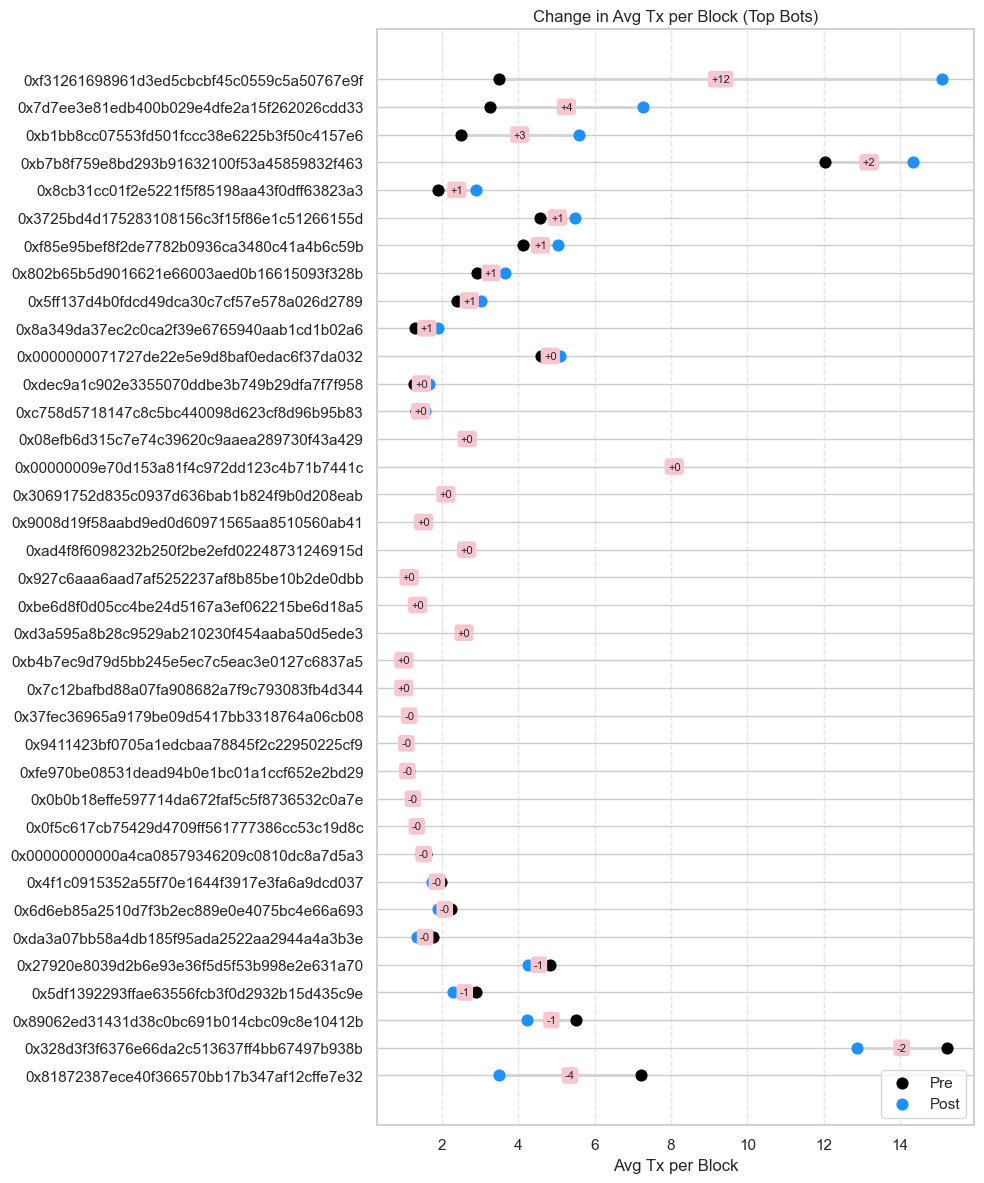

In [256]:
plot_delta_dumbbell(
    df=pivoted,
    pre_col="avg_tx_per_block_pre-flashblock",
    post_col="avg_tx_per_block_post-flashblock",
    delta_col="delta_tx_per_block",
    title="Change in Avg Tx per Block (Top Bots)",
    xlabel="Avg Tx per Block"
)


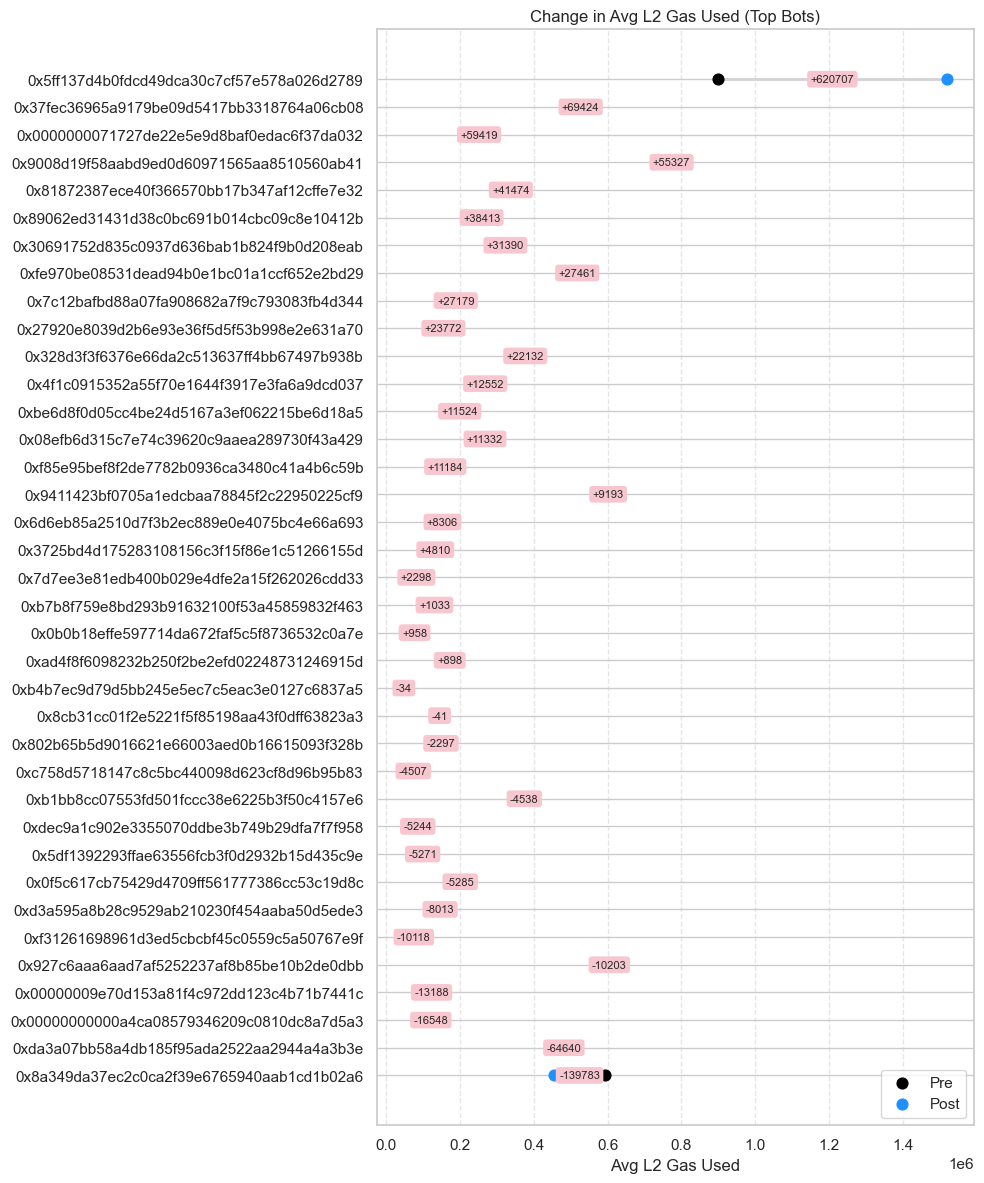

In [258]:
plot_delta_dumbbell(
    df=pivoted,
    pre_col="avg_l2_gas_used_pre-flashblock",
    post_col="avg_l2_gas_used_post-flashblock",
    delta_col="delta_gas_used",
    title="Change in Avg L2 Gas Used (Top Bots)",
    xlabel="Avg L2 Gas Used"
)


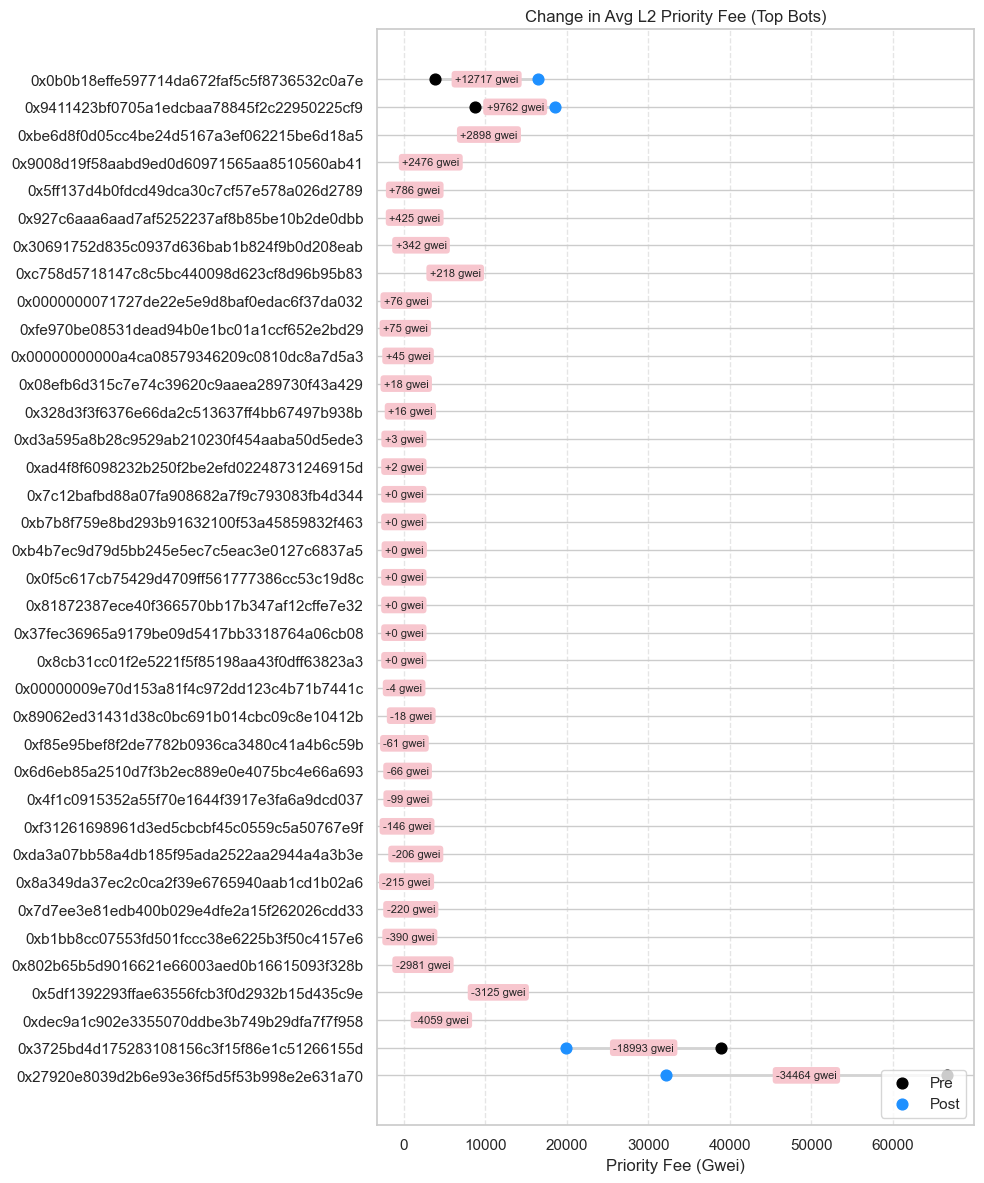

In [237]:
pivoted["gwei_pre"] = pivoted["avg_l2_priority_fee_pre-flashblock"] * 1e9
pivoted["gwei_post"] = pivoted["avg_l2_priority_fee_post-flashblock"] * 1e9
pivoted["delta_gwei"] = pivoted["gwei_post"] - pivoted["gwei_pre"]

plot_delta_dumbbell(
    df=pivoted,
    pre_col="gwei_pre",
    post_col="gwei_post",
    delta_col="delta_gwei",
    title="Change in Avg L2 Priority Fee (Top Bots)",
    xlabel="Priority Fee (Gwei)",
    unit=" gwei"
)


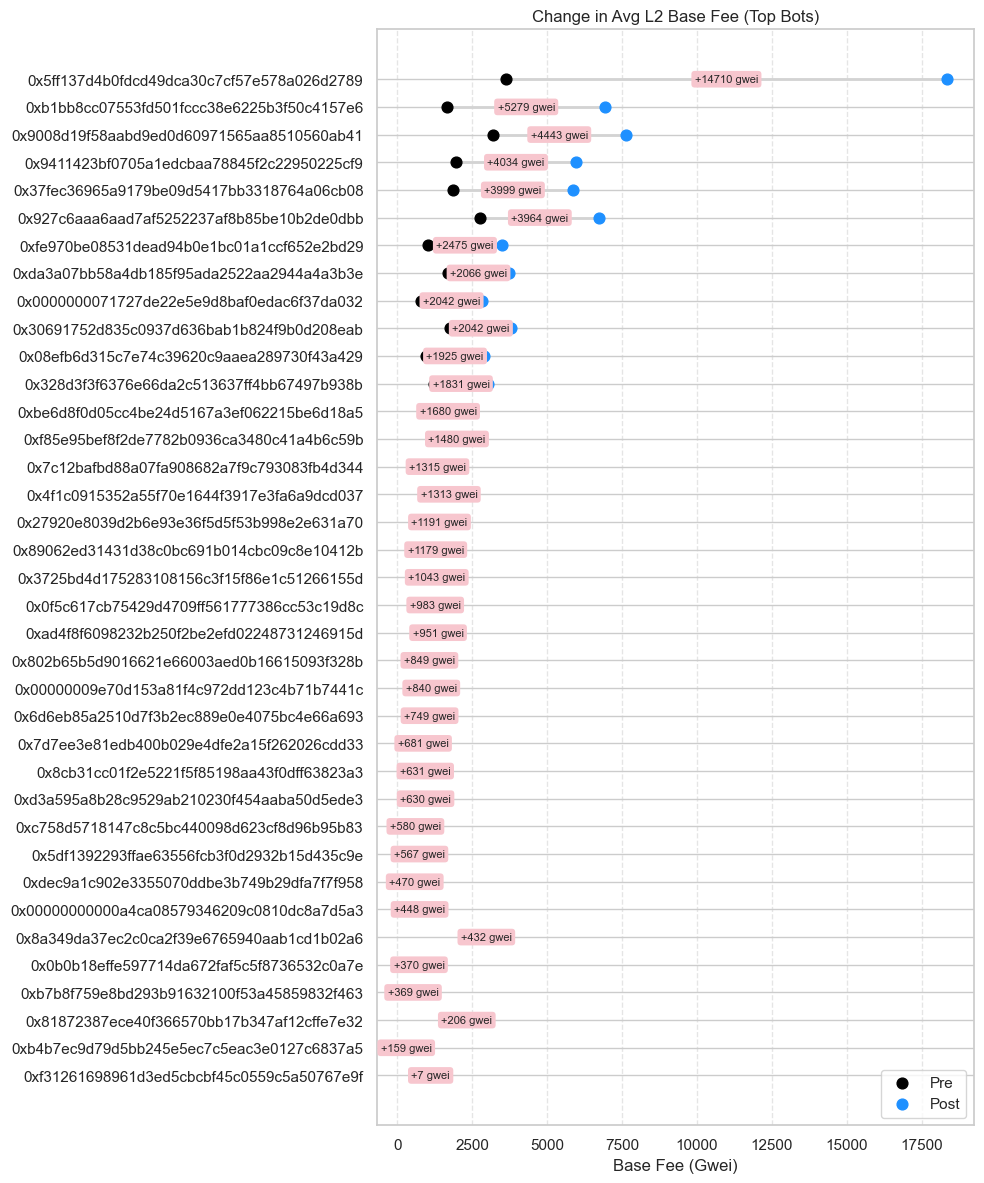

In [238]:
pivoted["gwei_pre"] = pivoted["avg_l2_base_fee_pre-flashblock"] * 1e9
pivoted["gwei_post"] = pivoted["avg_l2_base_fee_post-flashblock"] * 1e9
pivoted["delta_gwei"] = pivoted["gwei_post"] - pivoted["gwei_pre"]

plot_delta_dumbbell(
    df=pivoted,
    pre_col="gwei_pre",
    post_col="gwei_post",
    delta_col="delta_gwei",
    title="Change in Avg L2 Base Fee (Top Bots)",
    xlabel="Base Fee (Gwei)",
    unit=" gwei"
)

In [216]:
df_single_period_bots = df_top_bots.filter(~pl.col("to_address").is_in(top_bot_with_both_periods["to_address"]))
df_single_period_bots

flashblock_period,to_address,tx_count,block_count,total_fee,total_l1_fee,total_l2_base_fee,total_l2_priority_fee,total_l2_legacy_fee,total_gas_used,total_success,avg_tx_per_block,avg_tx_fee,avg_l1_fee,avg_l2_base_fee,avg_l2_priority_fee,avg_l2_legacy_fee,avg_l2_gas_used,avg_pct_l1_fee,avg_pct_l2_base_fee,avg_pct_l2_priority_fee,avg_pct_l2_legacy_fee
str,str,u32,u32,f64,f64,f64,f64,f64,i64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""post-flashblock""","""0xb533f31b21c2b0189bce07f4854775bc947a3b6d""",798868,90040,4.457701,0.037178,3.734255,0.686268,0.0,369550128344,798868,8.872368,0.000006,4.6538e-8,0.000005,8.5905e-7,0.0,462592.228433,1.245856,83.714552,15.039591,0.0
"""pre-flashblock""","""0x12387c3096afbcc7750b51869fe1e5fbde390792""",42817,10746,0.037183,0.000335,0.014703,0.022145,5.2748e-8,8241796837,42817,3.984459,8.6841e-7,7.8190e-9,3.4339e-7,5.1720e-7,1.2319e-12,192488.890791,1.242545,36.064723,62.691368,0.001364
"""post-flashblock""","""0x23ede1e5e3ced86af7d1de906a7f2df4d250927f""",172718,716,1.671208,0.000985,1.513055,0.157167,0.0,8160813074,172718,241.226257,0.00001,5.7028e-9,0.000009,9.0997e-7,0.0,47249.349078,0.158049,84.413114,15.428837,0.0
"""post-flashblock""","""0x4544030f1fb8d057c28849f4625229dcf84e92a4""",96540,22725,0.1024,0.001028,0.092889,0.008482,0.0,9906770735,96540,4.248185,0.000001,1.0651e-8,9.6218e-7,8.7863e-8,0.0,102618.300549,4.304578,84.568152,11.12727,0.0
"""post-flashblock""","""0x997753519f77721cc346d1485252cfcf632dac67""",364946,55249,0.900832,0.009059,0.678593,0.21318,0.0,114427741030,364946,6.605477,0.000002,2.4824e-8,0.000002,5.8414e-7,0.0,313547.048139,1.15341,70.027129,28.819461,0.0
"""post-flashblock""","""0x0b17c17ea37bc7213ef12ba29de7cd42c494a484""",95708,230,0.506619,0.001343,0.42177,0.083506,0.0,4650846328,95708,416.121739,0.000005,1.4033e-8,0.000004,8.7251e-7,0.0,48594.123041,0.67993,70.410828,28.909242,0.0
"""post-flashblock""","""0x9fb0f25859d505774ee4e895be5d122147b5c7a3""",355764,67360,1.242314,0.004787,1.044582,0.192946,0.0,106392995015,355764,5.281532,0.000003,1.3454e-8,0.000003,5.4234e-7,0.0,299054.977499,0.462943,79.98335,19.553707,0.0
"""post-flashblock""","""0x5874d90fdbaa95c031766f2a6843e276859456af""",1165861,124808,2.660456,0.033419,2.426197,0.20084,0.0,287541266566,1165830,9.341236,0.000002,2.8665e-8,0.000002,1.7227e-7,0.0,246634.261345,1.538368,86.380686,12.080946,0.0
"""post-flashblock""","""0x0a1558c4e5129b897adcb0997b6449463825a532""",429657,62024,0.158286,0.005988,0.131943,0.020356,0.0,22554252618,429657,6.92727,3.6840e-7,1.3936e-8,3.0709e-7,4.7378e-8,0.0,52493.623095,6.763282,77.614708,15.62201,0.0


In [ ]:
addresses = (
    df_top_bots
    .filter(pl.col("flashblock_period") == "post-flashblock")
    .select("to_address")
    .unique()
    .to_series()
    .to_list()
)

filtered_df_granular = df_casted.filter(pl.col("to_address").is_in(addresses))
filtered_df_granular = filtered_df_granular.filter(pl.col("flashblock_period") == "post-flashblock")

In [ ]:
# Convert to list of addresses for native Polars expression
single_period_addresses = df_single_period_bots.select("to_address").to_series().to_list()

bot_type_expr = (
    pl.when(pl.col("to_address").is_in(single_period_addresses))
    .then(pl.lit("post-flashblock only"))
    .otherwise(pl.lit("dual periods"))
    .alias("bot_type")
)

filtered_df_granular = filtered_df_granular.with_columns(bot_type_expr)

In [311]:
txs_per_block_df = (
    filtered_df_granular
    .group_by(["to_address", "bot_type", "block_number"])
    .agg([
        pl.len().alias("txs_in_block")
    ])
)

txs_per_block_summary = (
    txs_per_block_df
    .group_by(["to_address", "bot_type"])
    .agg([
        pl.col("txs_in_block").median().alias("median"),
        pl.col("txs_in_block").std().alias("std")
    ])
    .with_columns([
        pl.lit("txs_per_block").alias("metric")
    ])
    .to_pandas()
)


In [ ]:
df = filtered_df_granular.to_pandas()

metrics = [

    "l2_priority_fee_native",
    "l2_base_fee_native",
    "l2_gas_used",

]

summary_rows = []

for metric in metrics:
    grouped = (
        df.groupby(["to_address", "bot_type"])[metric]
        .agg(["median", "std"])
        .reset_index()
        .assign(metric=metric)
    )
    summary_rows.append(grouped)

summary_tx = pd.concat(summary_rows, ignore_index=True)

summary_tpb = (
    bot_density.groupby(["to_address", "bot_type"])["txs_per_block"]
    .agg(["median", "std"])
    .reset_index()
    .assign(metric="txs_per_block")
)

# Combine all
summary_df = pd.concat([summary_df, txs_per_block_summary], ignore_index=True)


In [ ]:
# Combine all
summary_df = pd.concat([summary_df, txs_per_block_summary], ignore_index=True)

summary_df.head()

,to_address,bot_type,median,std,metric
0,0x00000000000a4ca08579346209c0810dc8a7d5a3,dual periods,1.957944e-07,4.042024e-06,l2_priority_fee_native
1,0x0000000071727de22e5e9d8baf0edac6f37da032,dual periods,2.000097e-07,6.086921e-06,l2_priority_fee_native
2,0x00000009e70d153a81f4c972dd123c4b71b7441c,dual periods,1.507437e-08,5.320079e-08,l2_priority_fee_native
3,0x08efb6d315c7e74c39620c9aaea289730f43a429,dual periods,1.000572e-07,1.712049e-06,l2_priority_fee_native
4,0x0a1558c4e5129b897adcb0997b6449463825a532,post-flashblock only,3.146066e-08,1.113650e-07,l2_priority_fee_native


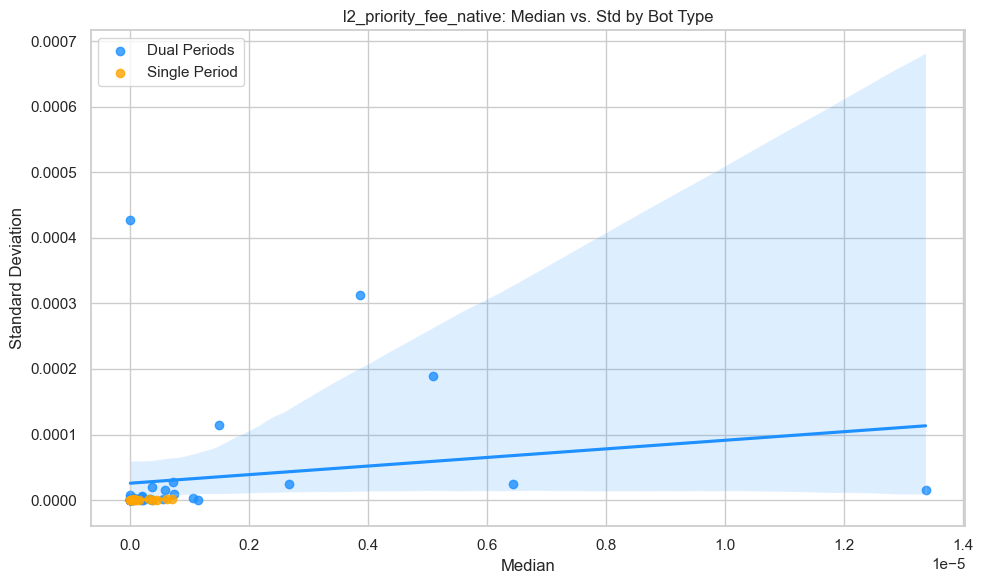

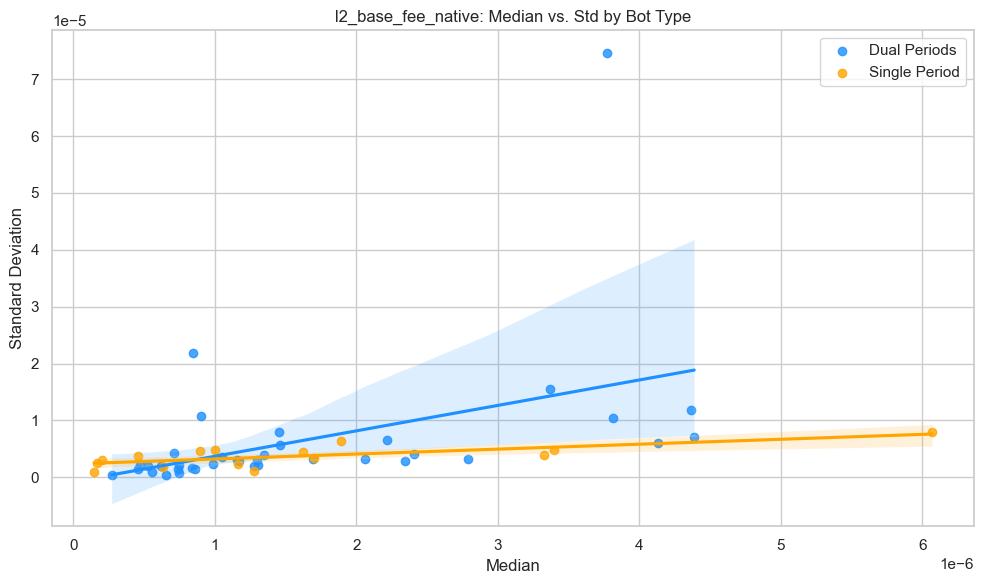

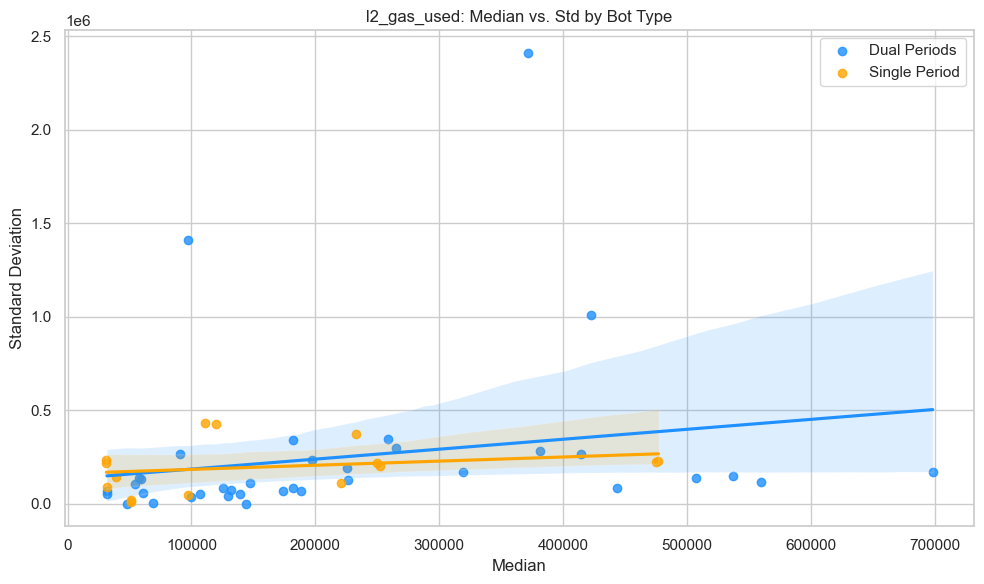

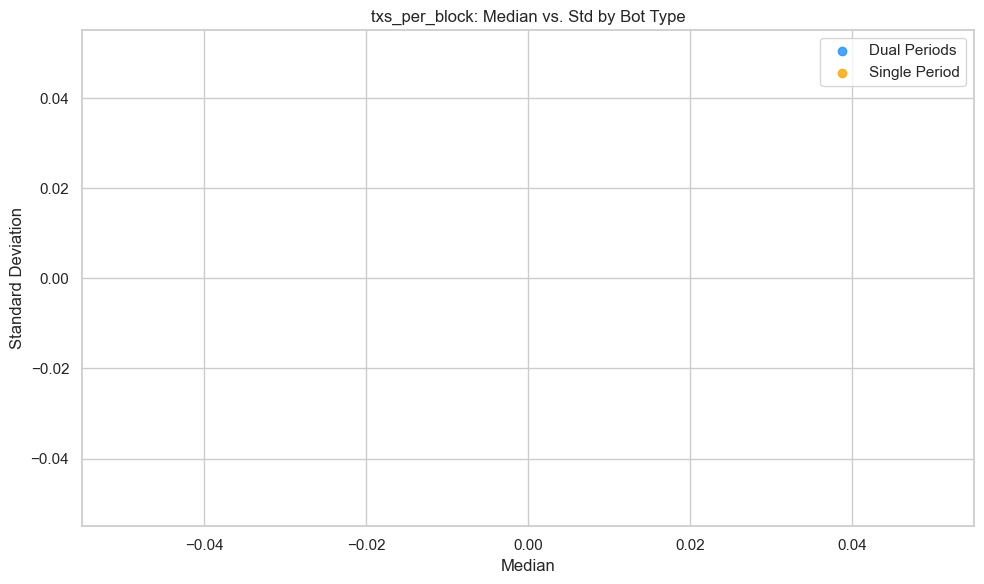

In [307]:
sns.set(style="whitegrid")

for metric in summary_df["metric"].unique():
    subset = summary_df[summary_df["metric"] == metric]

    plt.figure(figsize=(10, 6))
    sns.regplot(
        data=subset[subset["bot_type"] == "dual periods"],
        x="median", y="std", label="Dual Periods",
        scatter=True, color="dodgerblue"
    )
    sns.regplot(
        data=subset[subset["bot_type"] == "post-flashblock only"],
        x="median", y="std", label="Single Period",
        scatter=True, color="orange"
    )

    plt.title(f"{metric}: Median vs. Std by Bot Type")
    plt.xlabel("Median")
    plt.ylabel("Standard Deviation")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [309]:
bot_density.head()

,to_address,bot_type,tx_count,block_count,txs_per_block
0,0xb533f31b21c2b0189bce07f4854775bc947a3b6d,post-flashblock only,798868,90040,8.872368
1,0x5ff137d4b0fdcd49dca30c7cf57e578a026d2789,dual periods,413018,136310,3.029990
2,0x927c6aaa6aad7af5252237af8b85be10b2de0dbb,dual periods,42067,36002,1.168463
3,0x8a349da37ec2c0ca2f39e6765940aab1cd1b02a6,dual periods,79009,41513,1.903235
4,0xf5bdf46b89e75ae61fdf2374235f53284fa8193f,post-flashblock only,187084,36931,5.065771
